16/16 [==============================] - 0s 763us/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean     -0.033503   -0.052997      -0.024691          0.028476   
std       0.256049    0.255933       0.275665          0.290731   
min      -0.980336   -0.818234      -0.814339         -1.052857   
25%      -0.199350   -0.200026      -0.205888         -0.172790   
50%      -0.029945   -0.054478      -0.022452          0.004043   
75%       0.122147    0.098506       0.141445          0.204472   
max       0.737478    0.876813       0.920448          1.090292   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean             0.018854           -0.002561             0.030887   
std              0.245374            0.236454             0.262728   
min             -0.696933           -0.9023

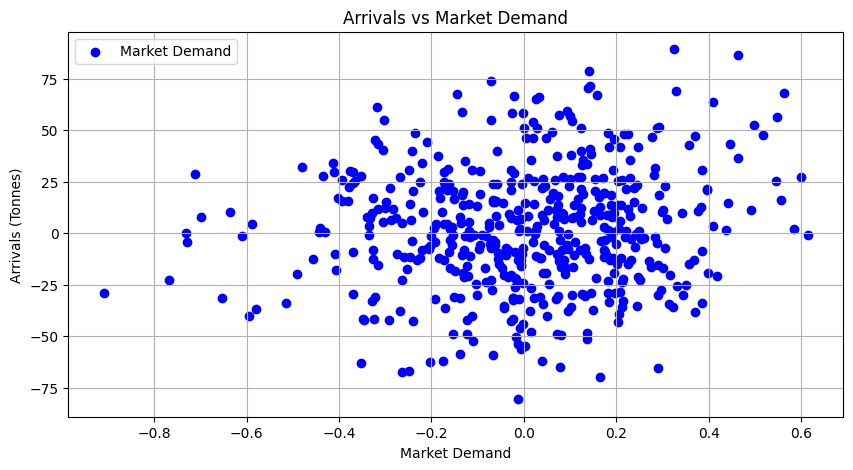

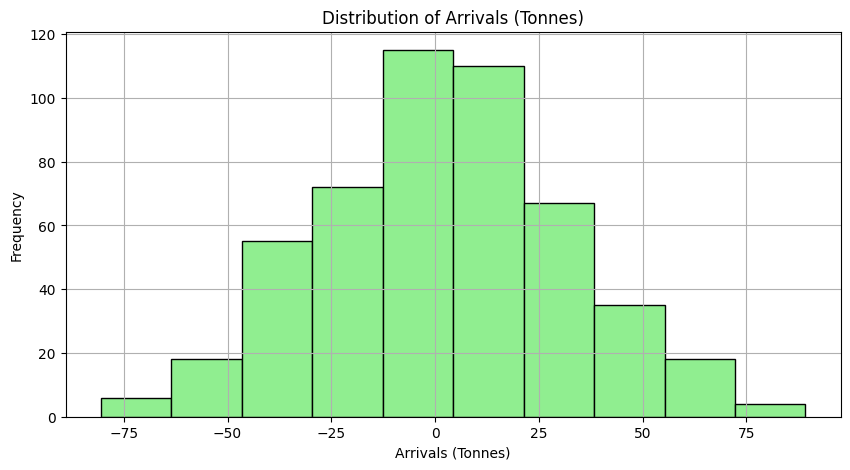

Initial Mean Squared Error: 348.9247490117655
Iteration 1: Adjusted MSE: 646.1498522339583
Iteration 2: Adjusted MSE: 639.0398058671155
Iteration 3: Adjusted MSE: 638.6857645882044
Iteration 4: Adjusted MSE: 627.9483131646646
Iteration 5: Adjusted MSE: 617.9467467726067


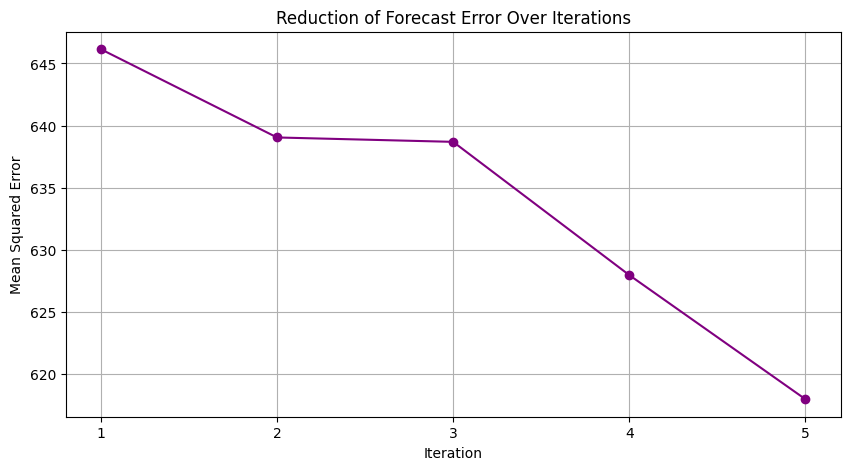

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())

# Correlation matrix
print("\nCorrelation Matrix:")
print(df.corr())

# Visualizations
plt.figure(figsize=(10, 5))
plt.scatter(df['Market_Demand'], df['Arrivals_Tonnes'], color='blue', label='Market Demand')
plt.xlabel('Market Demand')
plt.ylabel('Arrivals (Tonnes)')
plt.title('Arrivals vs Market Demand')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df['Arrivals_Tonnes'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Arrivals (Tonnes)')
plt.xlabel('Arrivals (Tonnes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Part 3: Forecasting Model
X = df.drop('Arrivals_Tonnes', axis=1)
y = df['Arrivals_Tonnes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_initial = model.predict(X_test)

mse_initial = mean_squared_error(y_test, y_pred_initial)
print(f'Initial Mean Squared Error: {mse_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_values = []

# Define constants for optimization
total_arrivals_limit = sum(y_test) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 6):
    # Define objective function coefficients (minimize forecast error)
    c = np.abs(y_pred_initial - y_test.values)  # Coefficients based on initial forecast error

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_initial)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Total arrivals limit increases slightly with each iteration

    # Bounds for each variable (non-negative arrivals, adjust slightly)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_initial]

    # Solve the optimization problem using linprog
    result = linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        adjusted_arrivals = result.x
        mse_adjusted = mean_squared_error(adjusted_arrivals, y_test)
        mse_values.append(mse_adjusted)
        iterations.append(iteration)
        print(f"Iteration {iteration}: Adjusted MSE: {mse_adjusted}")
    else:
        print("No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_values, marker='o', color='purple')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.grid()
plt.show()


16/16 [==============================] - 0s 1ms/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean      0.038037    0.011104      -0.019162          0.032920   
std       0.228276    0.254248       0.270011          0.289523   
min      -0.639283   -0.974972      -0.934140         -1.339850   
25%      -0.109779   -0.144497      -0.188127         -0.153354   
50%       0.028431    0.009410      -0.016724          0.033436   
75%       0.175509    0.180909       0.134514          0.208329   
max       0.997289    0.809398       0.807548          0.853728   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean            -0.059301            0.048215             0.033475   
std              0.265620            0.247068             0.264804   
min             -0.982092           -0.615495

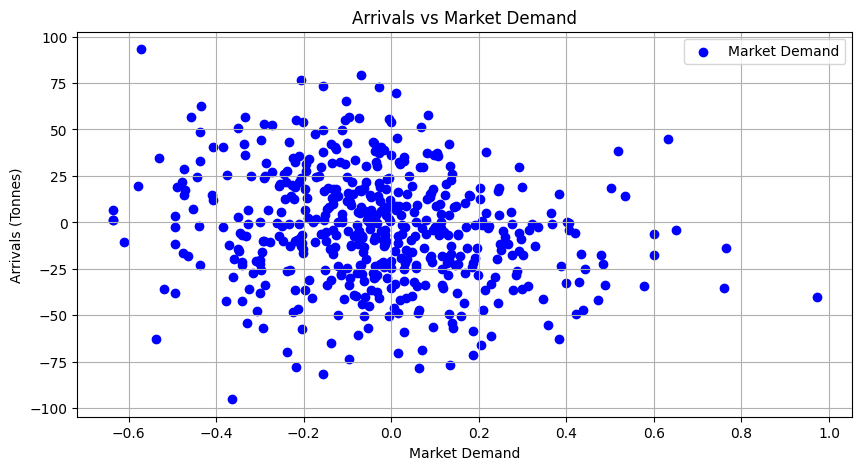

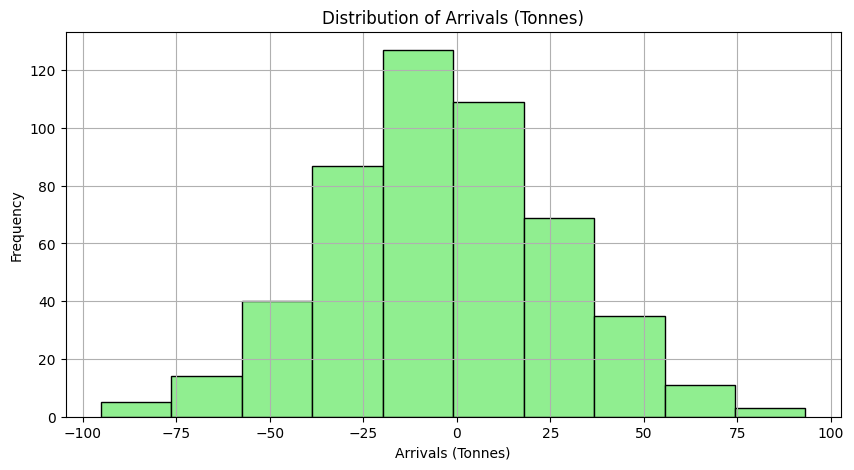

Initial Mean Squared Error: 480.7326033623831
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
Iteration 22: Adjusted MSE: 983.0246823542943
Iteration 23: Adjusted MSE: 973.6265454396581
Iteration 24: Adjusted MSE: 971.1724054673407
Iteration 25: Adjusted MSE: 960.94757484928
Iteration 26: Adjusted MSE: 956.7517949350033
Iteration 27: Adjusted MSE: 945.8099688803724
Iteration 28: Adjusted MSE: 935.722904530456
Iteration 29: Adjusted MSE: 930.3482655529995
Iteration 30: Adjusted

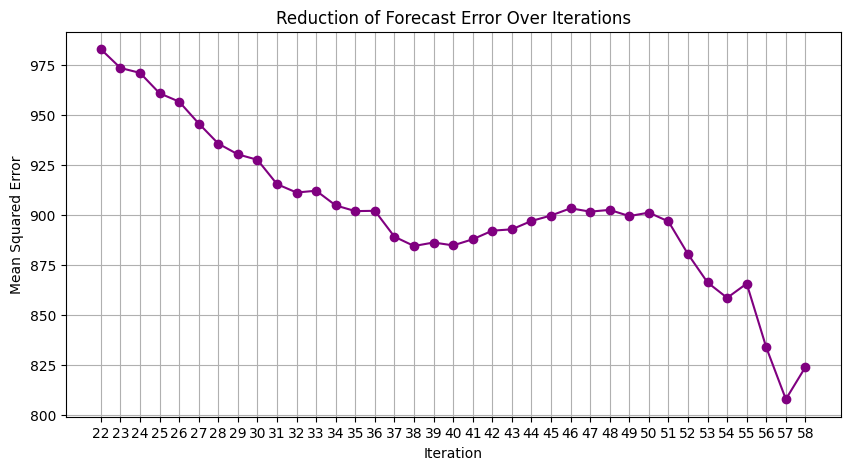

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())

# Correlation matrix
print("\nCorrelation Matrix:")
print(df.corr())

# Visualizations
plt.figure(figsize=(10, 5))
plt.scatter(df['Market_Demand'], df['Arrivals_Tonnes'], color='blue', label='Market Demand')
plt.xlabel('Market Demand')
plt.ylabel('Arrivals (Tonnes)')
plt.title('Arrivals vs Market Demand')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df['Arrivals_Tonnes'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Arrivals (Tonnes)')
plt.xlabel('Arrivals (Tonnes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Part 3: Forecasting Model
X = df.drop('Arrivals_Tonnes', axis=1)
y = df['Arrivals_Tonnes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_initial = model.predict(X_test)

mse_initial = mean_squared_error(y_test, y_pred_initial)
print(f'Initial Mean Squared Error: {mse_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_values = []

# Define constants for optimization
total_arrivals_limit = sum(y_test) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 1000):  
    # objective function coefficients (minimize forecast error)
    c = np.abs(y_pred_initial - y_test.values)  # Coefficients based on initial forecast error

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_initial)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Gradually increase the total arrivals limit

    # Bounds for each variable (non-negative arrivals, adjust slightly)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_initial]

    # Solve the optimization problem using linprog
    result = linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        adjusted_arrivals = result.x
        mse_adjusted = mean_squared_error(adjusted_arrivals, y_test)
        mse_values.append(mse_adjusted)
        iterations.append(iteration)
        print(f"Iteration {iteration}: Adjusted MSE: {mse_adjusted}")
    else:
        print("No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_values, marker='o', color='purple')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.grid()
plt.show()


16/16 [==============================] - 0s 1ms/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean      0.036295   -0.010372      -0.058039         -0.005685   
std       0.269279    0.250441       0.259495          0.261461   
min      -0.735492   -0.827927      -0.979408         -1.105461   
25%      -0.132124   -0.164161      -0.210683         -0.158823   
50%       0.022363   -0.009662      -0.038297         -0.008010   
75%       0.174663    0.137693       0.119052          0.156073   
max       1.101551    0.833454       0.651097          0.713238   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean            -0.006780            0.004152            -0.001500   
std              0.265479            0.225986             0.266824   
min             -0.939873           -0.811560

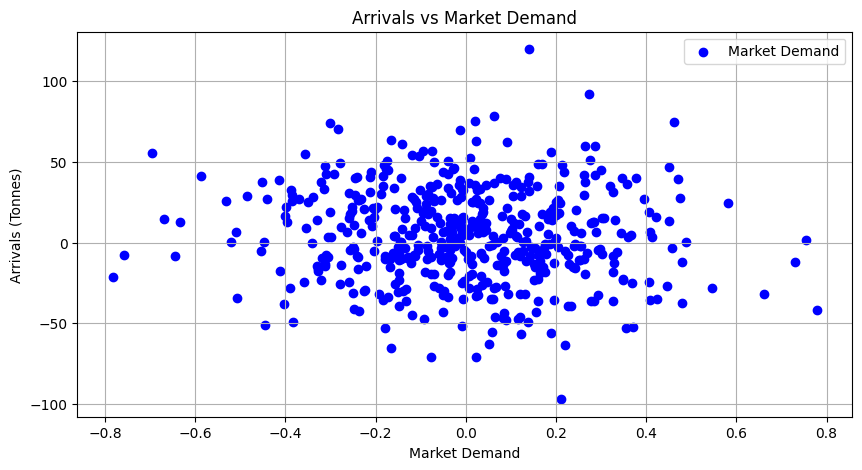

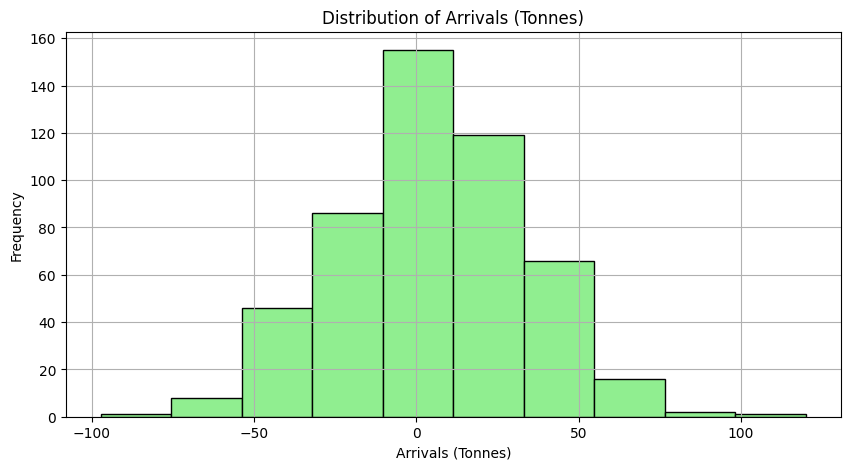

Initial Mean Squared Error: 404.8922584592113
Iteration 1: Adjusted MSE: 587.5637054299045
Iteration 2: Adjusted MSE: 582.8088436302875
Iteration 3: Adjusted MSE: 576.7194290978185
Iteration 4: Adjusted MSE: 562.1064080957618
Iteration 5: Adjusted MSE: 537.7170704446838
Iteration 6: Adjusted MSE: 521.327732793606
Iteration 7: Adjusted MSE: 523.1184434399881
Iteration 8: Adjusted MSE: 530.8808471356446
Iteration 9: Adjusted MSE: 527.0006706120492
Iteration 10: Adjusted MSE: 509.68687880365854
Iteration 11: Adjusted MSE: 499.5253055288143
Iteration 12: Adjusted MSE: 506.34330171459527
Iteration 13: Adjusted MSE: 505.1030790238713
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal solution found.
No optimal so

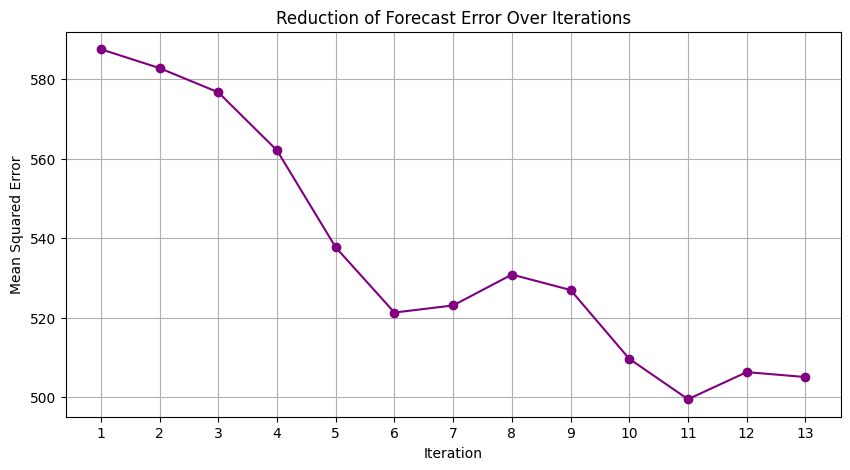

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())

# Correlation matrix
print("\nCorrelation Matrix:")
print(df.corr())

# Visualizations
plt.figure(figsize=(10, 5))
plt.scatter(df['Market_Demand'], df['Arrivals_Tonnes'], color='blue', label='Market Demand')
plt.xlabel('Market Demand')
plt.ylabel('Arrivals (Tonnes)')
plt.title('Arrivals vs Market Demand')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df['Arrivals_Tonnes'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Arrivals (Tonnes)')
plt.xlabel('Arrivals (Tonnes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Part 3: Forecasting Model
X = df.drop('Arrivals_Tonnes', axis=1)
y = df['Arrivals_Tonnes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_initial = model.predict(X_test)

mse_initial = mean_squared_error(y_test, y_pred_initial)
print(f'Initial Mean Squared Error: {mse_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_values = []

# Define constants for optimization
total_arrivals_limit = sum(y_test) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 30):  
    # objective function coefficients (minimize forecast error)
    c = np.abs(y_pred_initial - y_test.values)  # Coefficients based on initial forecast error

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_initial)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Gradually increase the total arrivals limit

    # Bounds for each variable (non-negative arrivals, adjust slightly)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_initial]

    # Solve the optimization problem using linprog
    result = linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        adjusted_arrivals = result.x
        mse_adjusted = mean_squared_error(adjusted_arrivals, y_test)
        mse_values.append(mse_adjusted)
        iterations.append(iteration)
        print(f"Iteration {iteration}: Adjusted MSE: {mse_adjusted}")
    else:
        print("No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_values, marker='o', color='purple')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.grid()
plt.show()


16/16 [==============================] - 0s 1ms/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean     -0.044250   -0.013313      -0.034654          0.060265   
std       0.253197    0.245098       0.229692          0.300674   
min      -1.182003   -0.781856      -0.748537         -0.911873   
25%      -0.176227   -0.155701      -0.186694         -0.127670   
50%      -0.042631   -0.004682      -0.048513          0.068867   
75%       0.119625    0.154118       0.107806          0.275275   
max       0.792494    0.743999       0.847059          0.994128   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean            -0.006802           -0.047781             0.029592   
std              0.262731            0.239003             0.259820   
min             -1.031787           -0.743754

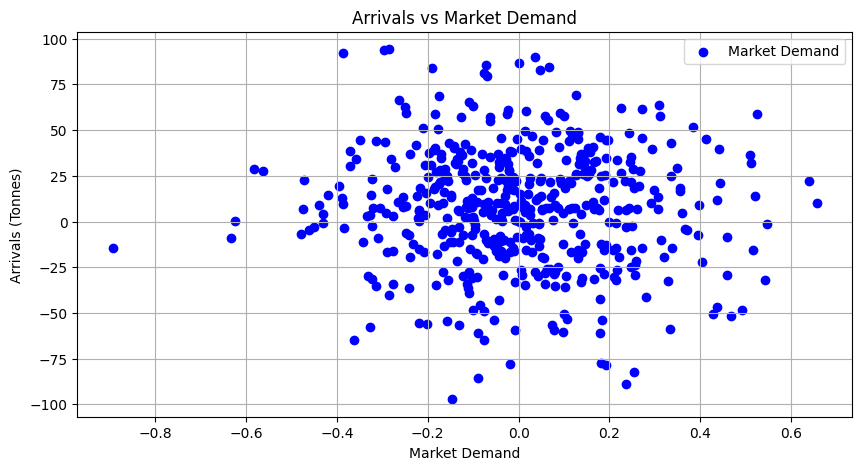

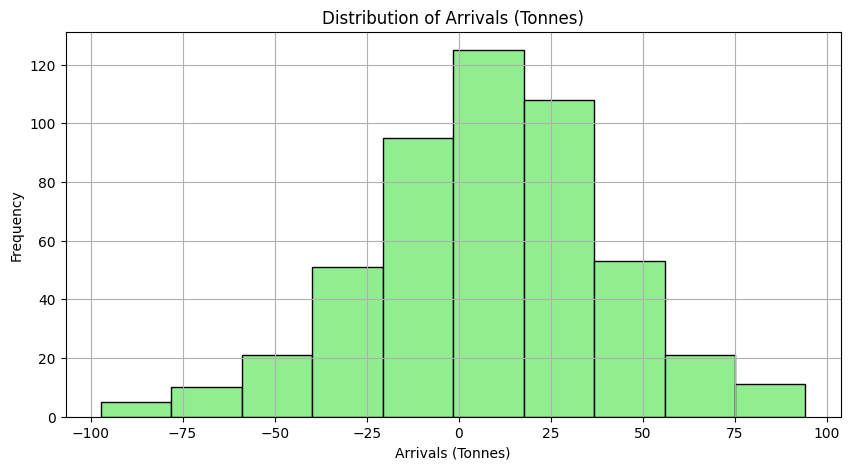

Initial Mean Squared Error: 826.1513743620831
Iteration 1: Adjusted MSE: 672.7095110869911
Iteration 2: Adjusted MSE: 665.3224441852594
Iteration 3: Adjusted MSE: 670.9238072449635
Iteration 4: Adjusted MSE: 670.5824347464328
Iteration 5: Adjusted MSE: 663.5622182989121
Iteration 6: Adjusted MSE: 662.957378406137
Iteration 7: Adjusted MSE: 648.5718374545992
Iteration 8: Adjusted MSE: 634.021044684036
Iteration 9: Adjusted MSE: 628.7357494172285
Iteration 10: Adjusted MSE: 626.5242155226456
Iteration 11: Adjusted MSE: 621.3891558568668
Iteration 12: Adjusted MSE: 629.2416669667599
Iteration 13: Adjusted MSE: 625.0218283001902
Iteration 14: Adjusted MSE: 622.2016891925075
Iteration 15: Adjusted MSE: 616.53737699011
Iteration 16: Adjusted MSE: 615.4895443350663
Iteration 17: Adjusted MSE: 624.5325675060128
Iteration 18: Adjusted MSE: 634.0931641556691
Iteration 19: Adjusted MSE: 644.0352837947348
Iteration 20: Adjusted MSE: 654.2918937043414
Iteration 21: Adjusted MSE: 642.7065075370664
I

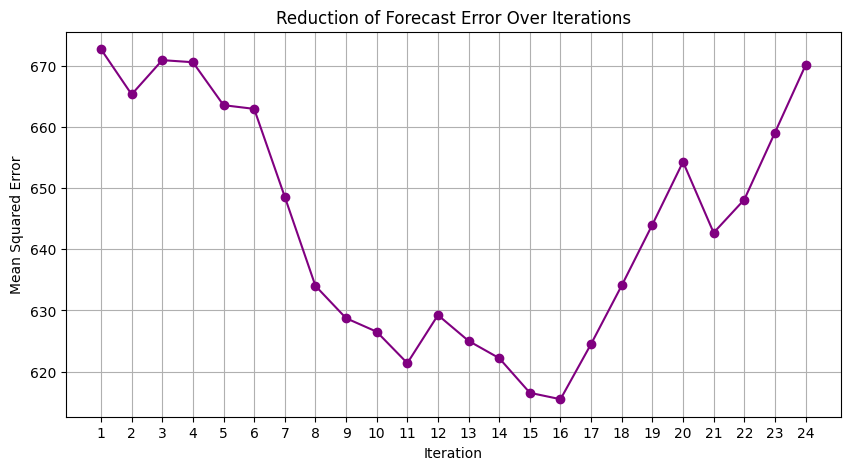

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog
from statsmodels.tsa.arima.model import ARIMA

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())

# Correlation matrix
print("\nCorrelation Matrix:")
print(df.corr())

# Visualizations
plt.figure(figsize=(10, 5))
plt.scatter(df['Market_Demand'], df['Arrivals_Tonnes'], color='blue', label='Market Demand')
plt.xlabel('Market Demand')
plt.ylabel('Arrivals (Tonnes)')
plt.title('Arrivals vs Market Demand')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df['Arrivals_Tonnes'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Arrivals (Tonnes)')
plt.xlabel('Arrivals (Tonnes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Part 3: Forecasting Model using ARIMA
# Ensure the target variable is a time series
# For ARIMA, you typically want a time series format, so we can sort by index.
# Assuming the data is sequential, we don't have a time index, so we'll create one.
df_sorted = df.sort_index()
X = df_sorted.drop('Arrivals_Tonnes', axis=1)
y = df_sorted['Arrivals_Tonnes']

# Splitting into train and test sets
train_size = int(len(df_sorted) * 0.8)
train, test = df_sorted[:train_size], df_sorted[train_size:]

# Fit the ARIMA model
model = ARIMA(train['Arrivals_Tonnes'], order=(5, 1, 0))  # You can tune the (p,d,q) parameters
model_fit = model.fit()

# Make predictions
y_pred_initial = model_fit.forecast(steps=len(test))

# Calculate the Mean Squared Error
mse_initial = mean_squared_error(test['Arrivals_Tonnes'], y_pred_initial)
print(f'Initial Mean Squared Error: {mse_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_values = []

# Define constants for optimization
total_arrivals_limit = sum(test['Arrivals_Tonnes']) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 25):  
    # objective function coefficients (minimize forecast error)
    c = np.abs(y_pred_initial - test['Arrivals_Tonnes'].values)  # Coefficients based on initial forecast error

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_initial)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Gradually increase the total arrivals limit

    # Bounds for each variable (non-negative arrivals, adjust slightly)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_initial]

    # Solve the optimization problem using linprog
    result = linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        adjusted_arrivals = result.x
        mse_adjusted = mean_squared_error(adjusted_arrivals, test['Arrivals_Tonnes'])
        mse_values.append(mse_adjusted)
        iterations.append(iteration)
        print(f"Iteration {iteration}: Adjusted MSE: {mse_adjusted}")
    else:
        print("No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_values, marker='o', color='purple')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.grid()
plt.show()

# # Part 5: Visualization of Forecast Error Reduction
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, mse_values, marker='o', color='purple', label='Adjusted MSE')
# plt.axhline(y=mse_initial, color='red', linestyle='--', label='Initial MSE')  # Adding a line for initial MSE
# plt.title('Reduction of Forecast Error Over Iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Mean Squared Error')
# plt.xticks(iterations)
# plt.legend()  # Adding a legend
# plt.grid()
# plt.show()



16/16 [==============================] - 0s 658us/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean     -0.046441    0.056890      -0.020882          0.108662   
std       0.242279    0.242578       0.266419          0.223669   
min      -0.945149   -0.861562      -0.789380         -0.654800   
25%      -0.199444   -0.101975      -0.188236         -0.049417   
50%      -0.058058    0.048768      -0.029773          0.103009   
75%       0.102926    0.210285       0.130814          0.251883   
max       0.644411    0.861052       1.210216          0.827396   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean            -0.011674            0.031552            -0.034155   
std              0.280420            0.273057             0.230297   
min             -1.253549           -0.9082

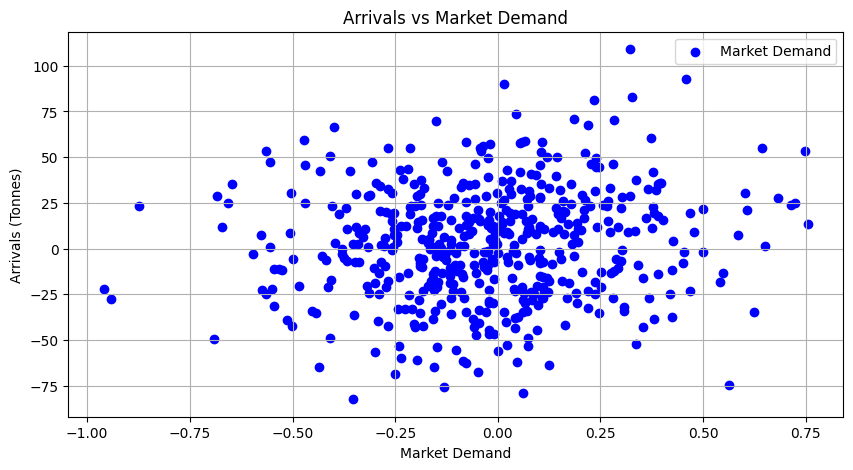

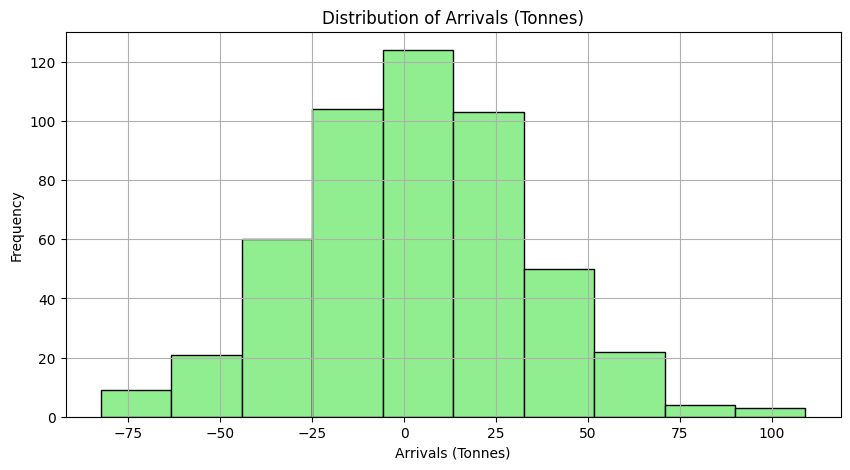

Initial Mean Squared Error: 1067.6532653199754
Iteration 1: Total Arrivals Limit = 358.89171596053865
Iteration 1: Adjusted MSE: 1388.226993056425
Iteration 2: Total Arrivals Limit = 358.89171596053865
Iteration 2: Adjusted MSE: 1672.1324357527558
Iteration 3: Total Arrivals Limit = 358.89171596053865
Iteration 3: Adjusted MSE: 1388.226993056425
Iteration 4: Total Arrivals Limit = 358.89171596053865
Iteration 4: Adjusted MSE: 1672.1324357527558
Iteration 5: Total Arrivals Limit = 358.89171596053865
Iteration 5: Adjusted MSE: 1388.226993056425
Iteration 6: Total Arrivals Limit = 358.89171596053865
Iteration 6: Adjusted MSE: 1672.1324357527558
Iteration 7: Total Arrivals Limit = 358.89171596053865
Iteration 7: Adjusted MSE: 1388.226993056425
Iteration 8: Total Arrivals Limit = 358.89171596053865
Iteration 8: Adjusted MSE: 1672.1324357527558
Iteration 9: Total Arrivals Limit = 358.89171596053865
Iteration 9: Adjusted MSE: 1388.226993056425
Iteration 10: Total Arrivals Limit = 358.89171596

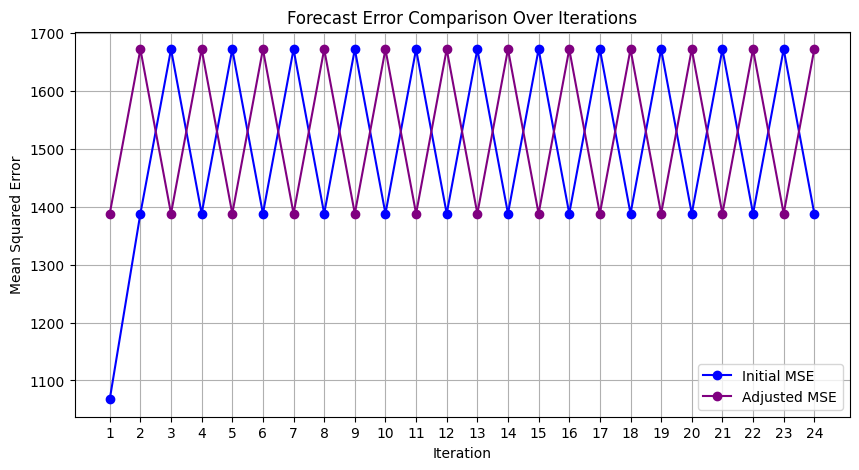

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog
from statsmodels.tsa.arima.model import ARIMA

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())

# Correlation matrix
print("\nCorrelation Matrix:")
print(df.corr())

# Visualizations
plt.figure(figsize=(10, 5))
plt.scatter(df['Market_Demand'], df['Arrivals_Tonnes'], color='blue', label='Market Demand')
plt.xlabel('Market Demand')
plt.ylabel('Arrivals (Tonnes)')
plt.title('Arrivals vs Market Demand')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df['Arrivals_Tonnes'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Arrivals (Tonnes)')
plt.xlabel('Arrivals (Tonnes)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Part 3: Forecasting Model using ARIMA
df_sorted = df.sort_index()
X = df_sorted.drop('Arrivals_Tonnes', axis=1)
y = df_sorted['Arrivals_Tonnes']

# Splitting into train and test sets
train_size = int(len(df_sorted) * 0.8)
train, test = df_sorted[:train_size], df_sorted[train_size:]

# Fit the ARIMA model
model = ARIMA(train['Arrivals_Tonnes'], order=(5, 1, 0))
model_fit = model.fit()

# Make predictions
y_pred_initial = model_fit.forecast(steps=len(test))

# Calculate the Mean Squared Error
mse_initial = mean_squared_error(test['Arrivals_Tonnes'], y_pred_initial)
print(f'Initial Mean Squared Error: {mse_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_values_initial = []  # Store initial MSE values
mse_values_adjusted = []  # Store adjusted MSE values

# Define constants for optimization
total_arrivals_limit = sum(test['Arrivals_Tonnes']) * 1.1

for iteration in range(1, 25):
    # Objective function coefficients: negative error to minimize it
    c = y_pred_initial - test['Arrivals_Tonnes'].values

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_initial)])
    b_eq = [total_arrivals_limit]

    # Print debug information
    print(f"Iteration {iteration}: Total Arrivals Limit = {b_eq[0]}")

    # Bounds for each variable
    bounds = [(0, None) for _ in range(len(y_pred_initial))]  # Remove max limit for testing

    # Solve the optimization problem using linprog
    result = linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        adjusted_arrivals = result.x
        mse_adjusted = mean_squared_error(adjusted_arrivals, test['Arrivals_Tonnes'])
        mse_values_adjusted.append(mse_adjusted)
        mse_values_initial.append(mean_squared_error(y_pred_initial, test['Arrivals_Tonnes']))
        iterations.append(iteration)
        print(f"Iteration {iteration}: Adjusted MSE: {mse_adjusted}")
        y_pred_initial = adjusted_arrivals  # Update predictions for the next iteration
    else:
        print("No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_values_initial, marker='o', color='blue', label='Initial MSE')
plt.plot(iterations, mse_values_adjusted, marker='o', color='purple', label='Adjusted MSE')
plt.title('Forecast Error Comparison Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.legend()
plt.grid()
plt.show()
